# PDF Processing

In [8]:
import pypdf as PDF
import wordcloud as WC
import re
from nltk import word_tokenize, sent_tokenize
import matplotlib.pyplot as plt

In [9]:
pdf = PDF.PdfReader("./data/the_alchemist.pdf")

In [3]:
total_pages = pdf.get_num_pages()
print("Total pages: ", total_pages)

Total pages:  158


In [4]:
pdf.metadata

{'/Title': 'The Alchemist',
 '/Author': 'Paulo Coelho & Alan R. Clarke',
 '/Keywords': 'General, Fiction, Literary, Alchemists, fables, Visionary & Metaphysical, Young men, Self-realization, Alchemy, Shepherds, Shepherds - Spain - Andalusia, Portuguese fiction, Andalusia (Spain)',
 '/Creator': 'Microsoft® Word 2016',
 '/CreationDate': "D:20160112234938+07'00'",
 '/ModDate': "D:20160112234938+07'00'",
 '/Producer': 'Microsoft® Word 2016'}

In [5]:
def read_pages(pdf, start=0, end=None):
    text = ""
    if (end is None) or (end > pdf.get_num_pages()):
        end = pdf.get_num_pages()

    for i in range(start, end ,1):
        try:
            page = pdf.get_page(i)
            text += page.extract_text()
        except:
            print("Error at page : ", i)

    return text

def preprocess(text):
    tokens = word_tokenize(text)
    return " ".join(tokens)

def process_pdf(pdf, start=0, end=None):
    text = read_pages(pdf, start=start, end=end)
    text = re.sub(r"[\n\t]", "", text)

    sentences = sent_tokenize(text)
    sentences = [i.lower() for i in sentences]
    return " ".join(sentences)

def split_pdf_text(text, threshold=5000):
    text_list = list()
    current_sentence = ""

    for i in text.split(". "):
        if len(current_sentence + i) < threshold:
            current_sentence += i
            current_sentence += ". "
        else:
            text_list.append(current_sentence)
            current_sentence = i
            current_sentence += ". "

    text_list.append(current_sentence)
    
    return text_list

In [18]:
text = read_pages(pdf, start=0)

In [59]:
text.__len__()

229480

In [60]:
preprocessed_text = re.compile(r"[\w\s\d]+").findall(text)
preprocessed_text = " ".join(preprocessed_text)

In [61]:
tokens = word_tokenize(preprocessed_text)
tokens.__len__()

42779

In [62]:
unique_tokens = set(tokens)
unique_tokens.__len__()

4478

In [63]:
tokens_freq = dict()

for token in tokens:
    if token not in tokens_freq.keys():
        tokens_freq[token] = 1
    else:
        tokens_freq[token] += 1

sorted_tokens_freq = sorted(tokens_freq.items(), key=lambda x: x[1], reverse=True)
sorted_tokens_freq[:10]

[('the', 3117),
 ('to', 1392),
 ('and', 1011),
 ('of', 1006),
 ('he', 814),
 ('a', 806),
 ('that', 775),
 ('was', 614),
 ('had', 586),
 ('I', 518)]

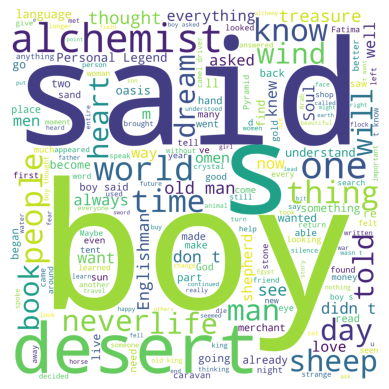

In [64]:
word_cloud = WC.WordCloud(width=2000, height=2000, background_color="white").generate(preprocessed_text)
word_cloud.to_file("./data/word_cloud.png")
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

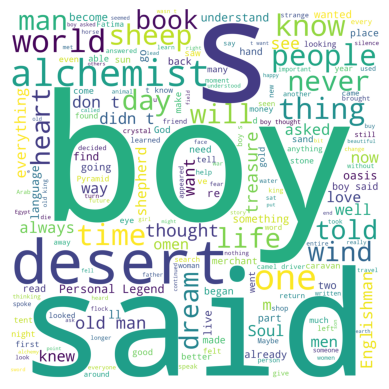

In [65]:
word_cloud = WC.WordCloud(width=2000, height=2000, background_color="white").generate(text)
word_cloud.to_file("./data/word_cloud_raw.png")
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

In [66]:
pdf_text = process_pdf(pdf, start=14)

pdf_text.__len__()

217970

In [67]:
tokens = word_tokenize(pdf_text)
tokens.__len__()

49076

In [68]:
set(tokens).__len__()

4159

In [69]:
split_pdf_text(pdf_text, threshold=10000).__len__()

22

In [70]:
sent_tokenize(pdf_text).__len__()

2370

# Text Summarization

In [71]:
from transformers import pipeline

summarizer = pipeline("summarization", model="pszemraj/led-base-book-summary", device="cuda")              # https://huggingface.co/pszemraj/led-base-book-summary

In [72]:
pdf_text = process_pdf(pdf, start=14, end=143)
pdf_text.__len__()

206204

In [73]:
def generate_short_summary(full_text, max_length=100, min_lenght=50, threshold=5000):
    sentences = sent_tokenize(full_text)
    text = ""

    for sentence in sentences:
        if len(text + sentence) < threshold:
            text += sentence
            text += ". "
        else:
            break

    summary = summarizer(text, max_length=max_length, min_length=min_lenght)

    return summary

In [74]:
summary = generate_short_summary(pdf_text, max_length=1000, min_lenght=500, threshold=10000)

Input ids are automatically padded from 2354 to 3072 to be a multiple of `config.attention_window`: 1024


In [75]:
summary = summary[0]["summary_text"]
summary

'Santiago arrives with his herd of sheep one day and decides to spend the night at an abandoned church. The roof has fallen off, and there is a sycamore tree on the spot where the sacristy used to be. He wakes up in the middle of the night reading a book he has just finished reading. When he re-enters the room, he finds that all the sheep have been sheared so that they can follow him wherever he goes. He begins to talk to the girl and her daughter about life in the andalusian countryside. His purpose in life is to travel, and he plans to show the girl how it is that a simple shepherd knows how to read. In conversation with the girl, the boy explains that people from all over the world have passed through this village, including those who live in Spain. They come to look at castles and see castles, but when they leave, they still think that the past was better than what they have now. As the boy grows up, he becomes more and more drawn to the idea of travel; he feels happy because he ha

# Text Question Answering

In [76]:
from transformers import pipeline

question_answering = pipeline("question-answering", model="deepset/roberta-base-squad2", device="cuda")    # https://huggingface.co/deepset/roberta-base-squad2

In [77]:
pdf_text = process_pdf(pdf, start=14, end=143)
pdf_text.__len__()

206204

In [78]:
qa_input = {
    "question": "what is the item used for the pillow ?",
    "context" : pdf_text
}

In [79]:
qa_output = question_answering(qa_input)

In [80]:
qa_output

{'score': 0.2694789469242096,
 'start': 634,
 'end': 667,
 'answer': 'book he had just finished reading'}

# Text to Speech

In [2]:
from pyttsx3 import init as pyt_init
import keyboard

speech_engine = pyt_init()

In [7]:
speech_engine.getProperty("voices")[0].name

'Microsoft David Desktop - English (United States)'

In [8]:
pdf_text = process_pdf(pdf, start=14, end=143)
pdf_text.__len__()

206204

In [9]:
voices = speech_engine.getProperty("voices")

for voice in voices:
    print(voice.name)

selected_voice = voices[0]

Microsoft David Desktop - English (United States)
Microsoft Zira Desktop - English (United States)


In [10]:
speech_engine.setProperty("rate",150)
speech_engine.setProperty("voice",selected_voice)

In [ ]:
def onStart(name):
    print("Press Q to stop playback", end="\n\n")

def onWord(name, location, length):
    if keyboard.is_pressed("q"):
        print("Press Q again to Quit and R to Resume")

        if keyboard.is_pressed("q"):
            speech_engine.stop()

In [12]:
speech_engine.connect("started-utterance", onStart)
speech_engine.connect("started-word", onWord)

{'topic': 'started-word',
 'cb': <function __main__.onWord(name, location, length)>}

In [13]:
speech_engine.say(pdf_text)
speech_engine.startLoop()

Press Q to stop playback

Press Q again to Quit and R to Resume
